# PROJET_5 : Segmentez des clients d'un site de e-commerce

**Votre rôle est d’accompagner Olist dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.**  



In [2]:
# standard libraries import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter

##### Fonctions

In [3]:
def minis_boxplots_histograms(df, boxplot_cols, hist_cols):
    """
    display graphs from a dataframe,
    boxplots or histograms by lists (columns names) in arguments.
    3 graphs per row, auto-calculate number of rows.
    """

    cols = boxplot_cols + hist_cols
    num_cols = len(cols)
    num_rows = (
        num_cols + 2
    ) // 3  

    fig, axes = plt.subplots(
        nrows=num_rows, ncols=3, 
        figsize=(10, num_rows * 3)
    )

    for i, col in enumerate(cols):
        row = i // 3
        col_position = i % 3

        if col in boxplot_cols:
            sns.boxplot(y=df[col].dropna(), ax=axes[row, col_position])
        elif col in hist_cols:
            sns.histplot(df[col].dropna(), ax=axes[row, col_position], bins=30)

        axes[row, col_position].set_ylabel(col, fontsize=7)
        axes[row, col_position].tick_params(labelsize=6)
        axes[row, col_position].yaxis.set_major_formatter(
            FuncFormatter(format_func)
        )

    # delete empty graphs
    for j in range(i + 1, num_rows * 3):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout(pad=3.0)
    plt.show()


def format_func(value, tick_number):
    """formating scientific numbers in standard"""
    
    return f"{value:,.1f}".replace(",", " ")


def plot_categorical_distribution(data, column_name, size, log=False):
    """histogram for categorical feature in a dataframe"""
    
    plt.figure(figsize=size)
    counts = data[column_name].value_counts()
    percentages = [round(
        val / len(data[column_name]) * 100, 1
    ) for val in counts]
    ax = counts.plot(kind="bar", color="skyblue")
    for i, (count, percentage) in enumerate(zip(counts, percentages)):
        ax.text(i, count + (0.01 * count), f"{percentage}%", 
                ha="center", va="bottom")
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    if log:
        plt.yscale("log")
        plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
        plt.ylabel("Frequency (log scale)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

#####  

## Etape 1 : Répondez aux requêtes SQL

Diagramme de la BDD :

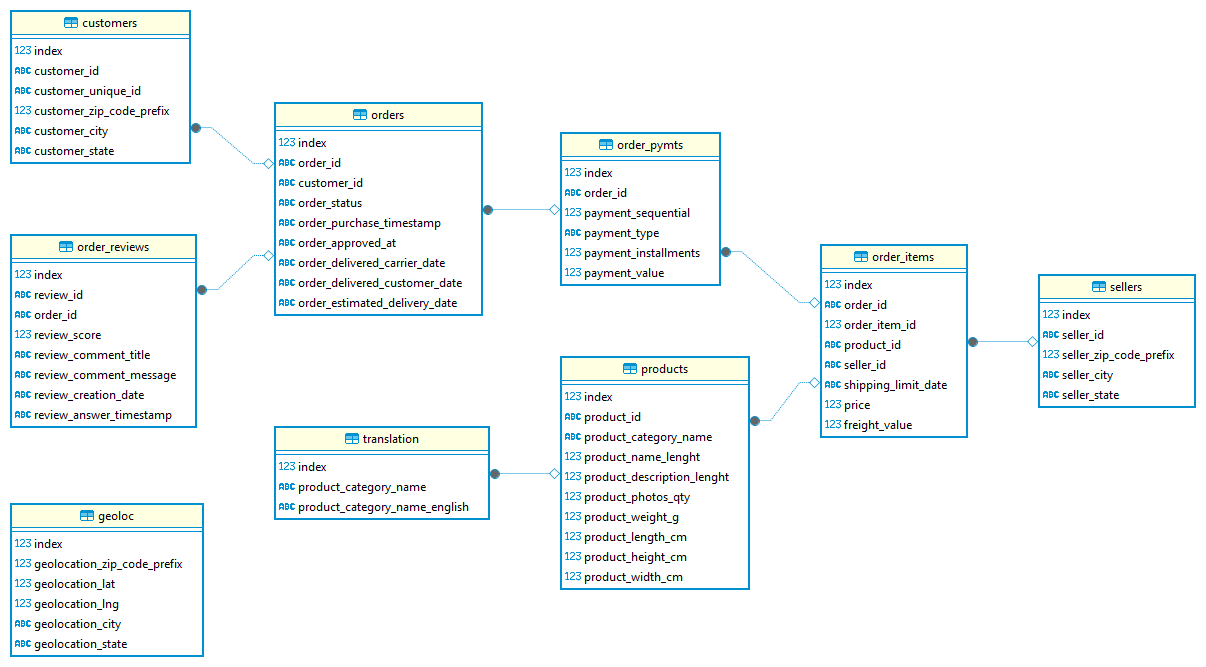

---
### 1.1 - Requête 1 :
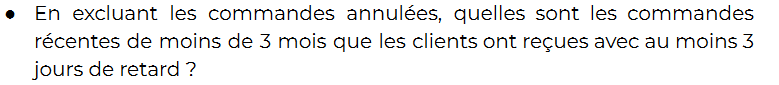

**Stratégie pour la requête :**
* Créer une table avec la date la plus récente des dates de commandes validées
* Calcul de la date 3 mois avant la date la plus récente
* Je sélectionne les commandes avec le statut "livrée", entre les 2 dates (plus récente et 3 mois avant) et dont la date de livraison est de plus de 3 jours après la date de livraison estimée.

```sql
WITH dates AS( 
	SELECT 
		MAX(o.order_approved_at) AS date_max, -- recupere la date max 
		DATE(MAX(o.order_approved_at), '-3 months') AS three_month_ago -- calcul 3 mois avant la date max
	FROM orders o
)
SELECT o.order_id, o.order_approved_at, o.order_delivered_customer_date - o.order_estimated_delivery_date AS delay FROM orders o
WHERE 
	o.order_status = 'delivered' -- commandes livrées
AND
	o.order_approved_at BETWEEN (SELECT three_month_ago from dates) AND (SELECT date_max from dates) -- commandes de - de 3 mois
AND
	o.order_delivered_customer_date > DATE(o.order_estimated_delivery_date, '+3 day'); -- commandes en retard de plus de 3 jours

**Résultats :**

In [4]:
request_1 = pd.read_csv("data/results/Request_1.csv")
request_1

,order_id,order_approved_at,delay
0,cfa4fa27b417971e86d8127cb688712f,2018-08-17 03:10:22,7.070613
1,234c056c50619f48da64f731c48242b4,2018-08-15 03:15:15,9.760208
2,8ad3f1d0f96992e43566c4c82c9f6c58,2018-07-17 21:35:17,11.169907
3,43f9a3d3e9d95525bfce717e31f72a56,2018-07-12 03:10:16,5.677616
4,7f579e203c931f3e8410103359c6d523,2018-08-02 18:43:43,4.841516
...,...,...,...
439,874a7690bc049bd4ce210d195bdfff7b,2018-08-02 13:05:56,5.660278
440,587e32dd528769d669d539531d32aeb5,2018-08-11 02:50:25,6.397581
441,3adb141ba4bd69dd7fe8d3fb733c6b74,2018-08-16 03:05:11,4.751991
442,4cf09d9e5ebbe0f91ddd7bf9aae891cd,2018-07-21 03:25:17,11.050521


---
### 1.2 - Requête 2 :
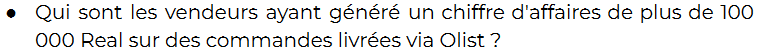

**Stratégie de la requête :**
* Création d'une table avec toutes les commandes, les paiements, les vendeurs et le statut des commandes
* Groupement par vendeur
* Filtre sur les commandes "livrées"
* Calcul de la somme des commandes par vendeurs
* Filtre sur les CA > 100.000 Real

```sql
WITH payments_data AS ( --creation d'une table avec les commandes, les paiements, les vendeurs et le statut des commandes
	SELECT oi.order_id, oi.seller_id, op.payment_value, o.order_status FROM order_items oi
	JOIN order_pymts op ON oi.order_id = op.order_id 
	JOIN orders o ON oi.order_id = o.order_id
	)
SELECT pd.seller_id, SUM(pd.payment_value) AS sales_revenue --recupere le seller_id et calcul le chiffre d'affaires
FROM payments_data pd
WHERE pd.order_status = 'delivered' --filtre sur les commandes livrees
GROUP by pd.seller_id --groupe par vendeur
HAVING sales_revenue > 100000; --filtre CA superieur à 100000

**Résultats :**

In [5]:
request_2 = pd.read_csv("data/results/Request_2.csv")
request_2

,seller_id,sales_revenue
0,1025f0e2d44d7041d6cf58b6550e0bfa,306000.35
1,1f50f920176fa81dab994f9023523100,289861.38
2,25c5c91f63607446a97b143d2d535d31,159673.13
3,3d871de0142ce09b7081e2b9d1733cb1,130150.09
4,46dc3b2cc0980fb8ec44634e21d2718e,142785.95
5,4869f7a5dfa277a7dca6462dcf3b52b2,261532.48
6,4a3ca9315b744ce9f8e9374361493884,295830.76
7,53243585a1d6dc2643021fd1853d8905,279843.42
8,5dceca129747e92ff8ef7a997dc4f8ca,131860.42
9,620c87c171fb2a6dd6e8bb4dec959fc6,142329.44


In [6]:
request_2.shape

(22, 2)

---
### 1.3 - Requête 3 :
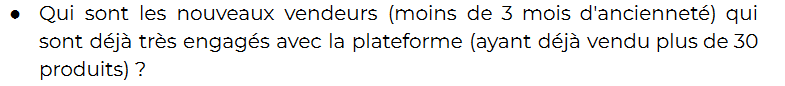

**Stratégie de la requête :**
* Récuparation de la date de commande passée, la plus récente
* Création d'une table des dates de la première vente d'un vendeur (commande passée)
* Table des vendeurs ayant réalisé leur première vente il y a moins de 3 mois (avant la date la plus récente)
* Calcul des ventes totales des vendeurs récents
* Filtre sur ceux qui ont > 30 ventes

```sql
WITH max_date AS ( --recupere la date la plus recente du dataset
	SELECT
		MAX(o.order_purchase_timestamp) AS date_max FROM orders o 
	),
	first_order_date AS ( --table des dates des premieres commandes de chaque vendeur
	SELECT 
		o.order_id, MIN(o.order_purchase_timestamp) AS first_purchase_date, oi.seller_id FROM orders o 
		JOIN order_items oi ON o.order_id = oi.order_id
		GROUP BY oi.seller_id
	),
	young_sellers AS ( --table de la liste des vendeurs avec - 3 mois d'anciennete
	SELECT 
		fod.seller_id, md.date_max FROM first_order_date fod
		CROSS JOIN max_date md
		WHERE fod.first_purchase_date > DATE(md.date_max, '-3 months')
	)
SELECT ys.seller_id, COUNT(oi.order_id) AS qty_orders FROM young_sellers ys --liste des jeunes vendeurs et le nombre de commandes
JOIN order_items oi ON ys.seller_id = oi.seller_id 
GROUP BY ys.seller_id
HAVING COUNT(oi.order_id) > 30; --filtre sur les vendeurs avec plus de 30 commandes
	

**Résultats :**

In [7]:
request_3 = pd.read_csv("data/results/Request_3.csv")
request_3

,seller_id,qty_orders
0,240b9776d844d37535668549a396af32,36
1,81f89e42267213cb94da7ddc301651da,52
2,d13e50eaa47b4cbe9eb81465865d8cfc,69


---
### 1.4 - Requête 4 :
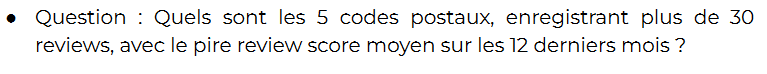

**Stratégie de requête :**  
* Calcul de la date 12 mois avant la date de commande, la plus récente
* Table des review_score avec les codes postaux, vendeurs, commandes, dates et filtre les 12 derniers mois
* Groupement par code postal
* Calcul du nombres de score par code postal
* Calcul moyen des scores par code postal
* Filtre les code postaux avec > de 30 scores
* Tri croissant
* Affichage des 5 premiers

```sql
WITH date_year AS ( --calcul de la date 1 an avant la date la plus recente du dataset
	SELECT
		DATE(MAX(o.order_purchase_timestamp), '-12 month') AS date_max FROM orders o 
	),
	sellers_list AS ( --table des review_score de moins de 12 mois avec code_postal
	SELECT
		ore.order_id, ore.review_score, ore.review_creation_date, oi.seller_id, s.seller_zip_code_prefix AS postal_code, dy.date_max FROM order_reviews ore
	JOIN order_items oi ON ore.order_id = oi.order_id
	JOIN sellers s ON oi.seller_id = s.seller_id
	CROSS JOIN date_year dy
	WHERE ore.review_creation_date > dy.date_max
	)
SELECT sl.postal_code, COUNT(sl.review_score) AS review_count, AVG(sl.review_score) AS mean_score --affiche code postal, nombre de review et moyenne des reviews
FROM sellers_list sl
GROUP BY sl.postal_code --groupe par code postal
HAVING COUNT(sl.review_score) > 30
ORDER BY mean_score ASC --rangement par score moyen les plus faibles 
LIMIT 5;

**Résultats :**

In [8]:
request_4 = pd.read_csv("data/results/Request_4.csv")
request_4

,postal_code,review_count,mean_score
0,6506,131,2.152672
1,22793,31,2.225806
2,3017,62,2.629032
3,37584,64,2.703125
4,13101,209,2.712919


---
---
---
## Etape 2 : Créez un fichier par client

**Stratégie :**

1. Définition des critères de segmentation
2. Récupération des données de le BDD par une requête SQL
3. Exploration du jeu de données
4. Feature Engineering et création du **Dataset par client**

---
### 2.1 - Définition des critères de segmentation :

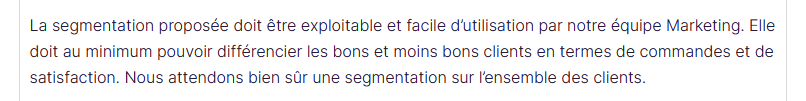

**Projet de segmentation :**

La segmentation proposée sera une combinaison de **RFM** (Récence, Fréquence, Montant) et de **comportement client** (satisfaction, diversité d'achats).  
 
**Objectifs :**
* Personnaliser les offres spéciales en ciblant les clients fidèles ou en réactivants les clients inactifs par des campagnes spécifiques.
* Identifier les clients à risques (faible récence ou faible satisfaction) et améliorer leur expérience avec des actions spécifiques.

**Critères de segmentation :**
- **Récence d'achat** : Date de la dernière commande
- **Fréquence d'achat** : Utiliser la fréquence des commandes pour identifier les clients réguliers, occasionnels, ou uniques.
- **Délai moyen entre 2 commandes** : Cela permet de préciser la fréquence et donc les clients plus réguliers.
- **Montant total des achats** : Analyser le montant total dépensé pour différencier les petits acheteurs des grands acheteurs.
- **Diversité des produits et vendeurs** : Utiliser la variété des catégories de produits achetés et le nombre de vendeurs pour identifier les clients qui achètent une large gamme de produits versus ceux qui se concentrent sur une seule catégorie.
- **Satisfaction client** : Intégrer les scores d'avis moyens pour évaluer la satisfaction, ce qui peut aider à distinguer les clients satisfaits, insatisfaits ou neutres.
- **Livraison** : Notions de commande **"reçue / ou pas"** et **"en retard / ou pas"**, ce qui peut expliquer une partie de la satisfaction.

Données à récupérer en SQL, **1 ligne par commande** :  

* Client : customer_unique_id
* Commande : order_id
* Vendeur : seller_id
* Tarif produit : price
* Frais de port par commande : freight_value
* Catégorie des produits : product_category_name_english
* Nombre de produits achetés par commande : qty_products_purchased
* Temps moyen entre les commandes par client : avg_days_between_orders
* Note donnée par le client (par commande) : review_score
* Date de la commande : order_purchase_timestamp
* Date de réception client : order_delivered_customer_date
* Date estimative de réception : estimated_delivery_date

---
---
### 2.2 - Récupération des données de base par requête SQL :

Extraction des données par SQL.

**Requête SQL :**

```sql
WITH dataset AS (
	SELECT DISTINCT
		oi.product_id, o.order_status, o.order_purchase_timestamp, o.customer_id, oi.order_id, oi.seller_id, oi.price, oi.freight_value, 
		ore.review_score, op.payment_value, c.customer_unique_id, c.customer_city, o.order_delivered_customer_date, o.order_status,
		o.order_estimated_delivery_date, p.product_category_name, t.product_category_name_english
	FROM order_items oi
	JOIN order_reviews ore ON oi.order_id = ore.order_id 
	JOIN order_pymts op ON oi.order_id = op.order_id 
	JOIN orders o ON oi.order_id = o.order_id 
	JOIN products p ON oi.product_id = p.product_id 
	JOIN "translation" t ON p.product_category_name = t.product_category_name 
	JOIN customers c ON o.customer_id = c.customer_id 
),
ordered_data AS (
    SELECT 
        d.order_purchase_timestamp, d.customer_unique_id, 
        LEAD(d.order_purchase_timestamp) OVER (PARTITION BY d.customer_unique_id ORDER BY d.order_purchase_timestamp) AS next_order_timestamp
    FROM 
        dataset d
),
qty_products AS (
    SELECT 
        COUNT(oi.product_id) AS qty_products_purchased, oi.order_id
    FROM order_items oi 
    GROUP BY oi.order_id 
),
order_count AS (
    SELECT 
        d.customer_unique_id, COUNT(d.order_id) AS order_count
    FROM dataset d
    GROUP BY d.customer_unique_id 
),
filtered_orders AS (
    SELECT 
        d.customer_unique_id,
        d.order_purchase_timestamp,
        JULIANDAY(od.next_order_timestamp) - JULIANDAY(d.order_purchase_timestamp) AS days_between_orders
    FROM dataset d
    JOIN ordered_data od ON d.customer_unique_id = od.customer_unique_id AND d.order_purchase_timestamp = od.order_purchase_timestamp
    WHERE od.next_order_timestamp IS NOT NULL
),
filtered_avg_days AS (
    SELECT
        customer_unique_id,
        AVG(days_between_orders) AS avg_days_between_orders
    FROM filtered_orders
    WHERE days_between_orders > 0 AND days_between_orders < 365 -- Filtre pour écarter les valeurs aberrantes
    GROUP BY customer_unique_id
),
max_date AS (
    SELECT MAX(o.order_purchase_timestamp) AS date_max FROM orders o 
)
SELECT 
    d.customer_unique_id, 
    d.order_id, 
    d.order_purchase_timestamp AS order_purchase_date,
    d.order_delivered_customer_date AS delivered_date,
    d.order_estimated_delivery_date AS estimated_delivery_date,
    d.order_status,
    d.seller_id,
    d.price, 
    d.freight_value, 
    d.product_category_name_english,
    d.customer_city,
    COALESCE(fa.avg_days_between_orders, 0) AS avg_days_between_orders,
    d.review_score,
    qp.qty_products_purchased
FROM dataset d
LEFT JOIN filtered_avg_days fa ON d.customer_unique_id = fa.customer_unique_id
LEFT JOIN qty_products qp ON d.order_id = qp.order_id
LEFT JOIN order_count oc ON d.customer_unique_id = oc.customer_unique_id


In [9]:
# dataset import
df = pd.read_csv("data/sources/dataset_all_features.csv")

In [10]:
df.shape

(104266, 14)

---
---
### 2.3 - Analyse exploratoire :

#### 2.3.1 - Exploration du Dataset :

In [11]:
# display dataframe's 5 first lines 
df.head()

,customer_unique_id,order_id,order_purchase_date,delivered_date,estimated_delivery_date,order_status,seller_id,price,freight_value,product_category_name_english,customer_city,avg_days_between_orders,review_score,qty_products_purchased
0,871766c5855e863f6eccc05f988b23cb,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29 00:00:00,delivered,48436dade18ac8b2bce089ec2a041202,58.90,13.29,cool_stuff,campos dos goytacazes,0.000000,5,1
1,eb28e67c4c0b83846050ddfb8a35d051,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15 00:00:00,delivered,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,pet_shop,santa fe do sul,145.221505,4,1
2,3818d81c6709e39d06b2738a8d3a2474,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05 00:00:00,delivered,5b51032eddd242adc84c38acab88f23d,199.00,17.87,furniture_decor,para de minas,0.000000,5,1
3,af861d436cfc08b2c2ddefd0ba074622,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20 00:00:00,delivered,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,perfumery,atibaia,0.000000,4,1
4,64b576fb70d441e8f1b2d7d446e483c5,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,2017-03-01 16:42:31,2017-03-17 00:00:00,delivered,df560393f3a51e74553ab94004ba5c87,199.90,18.14,garden_tools,varzea paulista,0.000000,5,1


In [12]:
# display dataframe's 5 last lines 
df.tail()

,customer_unique_id,order_id,order_purchase_date,delivered_date,estimated_delivery_date,order_status,seller_id,price,freight_value,product_category_name_english,customer_city,avg_days_between_orders,review_score,qty_products_purchased
104261,0c9aeda10a71f369396d0c04dce13a64,fffc94f6ce00a00581880bf54a75a037,2018-04-23 13:57:06,2018-05-10 22:56:40,2018-05-18 00:00:00,delivered,b8bc237ba3788b23da09c0f1f3a3288c,299.99,43.41,housewares,sao luis,0.0,5,1
104262,0da9fe112eae0c74d3ba1fe16de0988b,fffcd46ef2263f404302a634eb57f7eb,2018-07-14 10:26:46,2018-07-23 20:31:55,2018-08-01 00:00:00,delivered,f3c38ab652836d21de61fb8314b69182,350.00,36.53,computers_accessories,curitiba,0.0,5,1
104263,cd79b407828f02fdbba457111c38e4c4,fffce4705a9662cd70adb13d4a31832d,2017-10-23 17:07:56,2017-10-28 12:22:22,2017-11-10 00:00:00,delivered,c3cfdc648177fdbbbb35635a37472c53,99.90,16.95,sports_leisure,sao paulo,0.0,5,1
104264,eb803377c9315b564bdedad672039306,fffe18544ffabc95dfada21779c9644f,2017-08-14 23:02:59,2017-08-16 21:59:40,2017-08-25 00:00:00,delivered,2b3e4a2a3ea8e01938cabda2a3e5cc79,55.99,8.72,computers_accessories,vinhedo,0.0,5,1
104265,cd76a00d8e3ca5e6ab9ed9ecb6667ac4,fffe41c64501cc87c801fd61db3f6244,2018-06-09 17:00:18,2018-06-14 17:56:26,2018-06-28 00:00:00,delivered,f7ccf836d21b2fb1de37564105216cc1,43.00,12.79,bed_bath_table,botucatu,0.0,5,1


In [13]:
# converting date columns to datetime
df["order_purchase_date"] = pd.to_datetime(df["order_purchase_date"])
df["delivered_date"] = pd.to_datetime(df["delivered_date"])
df["estimated_delivery_date"] = pd.to_datetime(df["estimated_delivery_date"])

In [14]:
# column types and number of non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104266 entries, 0 to 104265
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_unique_id             104266 non-null  object        
 1   order_id                       104266 non-null  object        
 2   order_purchase_date            104266 non-null  datetime64[ns]
 3   delivered_date                 102095 non-null  datetime64[ns]
 4   estimated_delivery_date        104266 non-null  datetime64[ns]
 5   order_status                   104266 non-null  object        
 6   seller_id                      104266 non-null  object        
 7   price                          104266 non-null  float64       
 8   freight_value                  104266 non-null  float64       
 9   product_category_name_english  104266 non-null  object        
 10  customer_city                  104266 non-null  object        
 11  

---
#### 2.3.2 - Traitement des doublons :

In [15]:
# count duplicated lines
df.duplicated().sum()

4679

In [16]:
# check number of lines before deleting duplicated lines
df.shape

(104266, 14)

In [17]:
# deleting duplicated lines
df = df.drop_duplicates()

In [18]:
# check number of lines after deleting duplicated lines
df.shape

(99587, 14)

---
#### 2.3.3 - Traitement des manquants :

In [19]:
# check missing values
df.isna().sum()

customer_unique_id                  0
order_id                            0
order_purchase_date                 0
delivered_date                   2067
estimated_delivery_date             0
order_status                        0
seller_id                           0
price                               0
freight_value                       0
product_category_name_english       0
customer_city                       0
avg_days_between_orders             0
review_score                        0
qty_products_purchased              0
dtype: int64

**A. Traitement des manquants de la feature:  `delivered_date`**

In [20]:
df_na_date = df[df.delivered_date.isna()]
df_na_date.head(2)

,customer_unique_id,order_id,order_purchase_date,delivered_date,estimated_delivery_date,order_status,seller_id,price,freight_value,product_category_name_english,customer_city,avg_days_between_orders,review_score,qty_products_purchased
72,205d5aa158338f2b733a07326aae8c87,002f19a65a2ddd70a090297872e6d64e,2018-03-21 13:05:30,NaT,2018-04-16,shipped,1835b56ce799e6a4dc4eddc053f04066,53.98,23.31,bed_bath_table,camacari,0.0,3,1
78,ec979208947bbba310f2ad8e50963725,00310b0c75bb13015ec4d82d341865a4,2018-08-15 14:29:08,NaT,2018-08-29,canceled,a2deecd5398f5df4987110c80a1972a3,39.90,15.38,housewares,belo horizonte,0.0,1,1


Les commandes sans date de livraison sont des commandes **non reçues** ou **annulées**.  
Elles seront traitées plus tard dans le Feature Enginneering.

---
#### 2.3.4 - Statistiques descriptives :

In [21]:
# descriptive statistics of quantitative data
df.describe()

,order_purchase_date,delivered_date,estimated_delivery_date,price,freight_value,avg_days_between_orders,review_score,qty_products_purchased
count,99587,97520,99587,99587.000000,99587.000000,99587.000000,99587.000000,99587.000000
mean,2018-01-01 17:25:54.559340288,2018-01-15 04:46:10.932300800,2018-01-25 13:00:24.328476672,124.743146,20.167879,4.209668,4.081567,1.184371
min,2016-09-04 21:15:19,2016-10-11 13:46:32,2016-10-20 00:00:00,0.850000,0.000000,0.000000,1.000000,1.000000
25%,2017-09-13 15:48:41,2017-09-26 18:33:45,2017-10-04 00:00:00,40.990000,13.180000,0.000000,4.000000,1.000000
50%,2018-01-20 19:31:45,2018-02-03 11:53:30.500000,2018-02-16 00:00:00,79.000000,16.360000,0.000000,5.000000,1.000000
75%,2018-05-06 10:36:13,2018-05-16 19:43:08,2018-05-28 00:00:00,139.200000,21.300000,0.000000,5.000000,1.000000
max,2018-09-03 09:06:57,2018-10-17 13:22:46,2018-10-25 00:00:00,6735.000000,409.680000,364.975683,5.000000,21.000000
std,NaN,NaN,NaN,187.669610,15.918503,27.295687,1.348798,0.621786


In [22]:
# descriptive statistics of qualitative data
df.describe(include="object")

,customer_unique_id,order_id,order_status,seller_id,product_category_name_english,customer_city
count,99587,99587,99587,99587,99587,99587
unique,93396,96516,7,3028,71,4093
top,8d50f5eadf50201ccdcedfb9e2ac8455,ca3625898fbd48669d50701aba51cd5f,delivered,6560211a19b47992c3666cc44a7e94c0,bed_bath_table,sao paulo
freq,15,7,97521,1934,9858,15590


In [23]:
# number of unique values per column
df.nunique()

customer_unique_id               93396
order_id                         96516
order_purchase_date              95989
delivered_date                   93702
estimated_delivery_date            449
order_status                         7
seller_id                         3028
price                             5879
freight_value                     6954
product_category_name_english       71
customer_city                     4093
avg_days_between_orders           2080
review_score                         5
qty_products_purchased              17
dtype: int64

**Premiers éléments intéressants :**
* 96516 commandes pour 93396 clients uniques ==> peu de clients ont réalisés plusieurs commandes
* 3028 vendeurs
* 71 catégories de produits vendues
* Dates du dataset : du **2016-09-04** au **2018-09-03** / période : 2 années

---
#### 2.3.5 - Analyse des distributions et Outliers :

In [24]:
boxplot_cols = ["price", "freight_value", "review_score"]
hist_cols = [
    "product_category_name_english",
    "avg_days_between_orders",
    "qty_products_purchased",
]

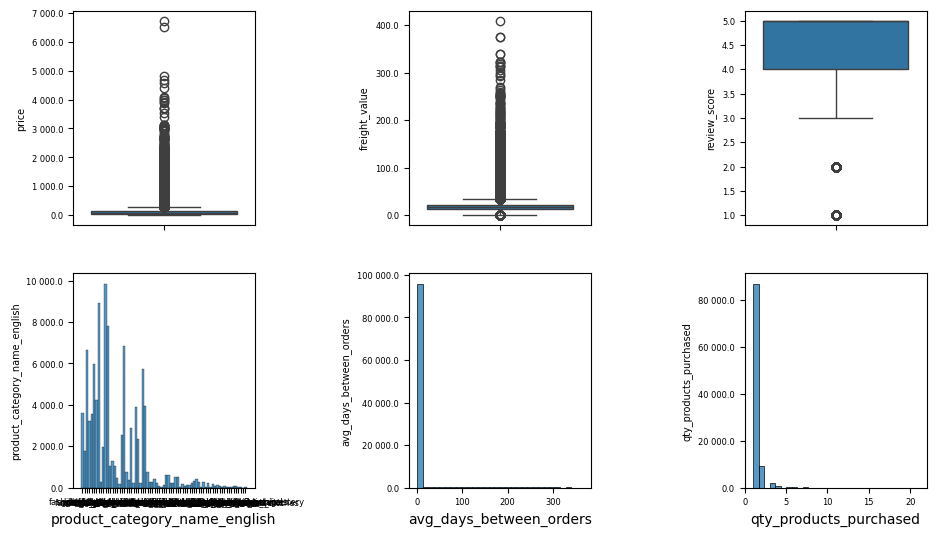

In [25]:
# display plots from custom function
minis_boxplots_histograms(df, boxplot_cols, hist_cols)

**Commentaires :**  
* Majorité des prix des articles et des frais de ports sont faibles, mais les outliers sont forts.
* La satisfaction client est majoritairement bonne.
* Peu de client achète plus d'une fois sur le site (majorité : 0 jour entre 2 commandes)
* Peu de client achète plusieurs produits par commande.


##### **A. Détails de la feature `price` :**

Text(0, 0.5, 'Frequence')

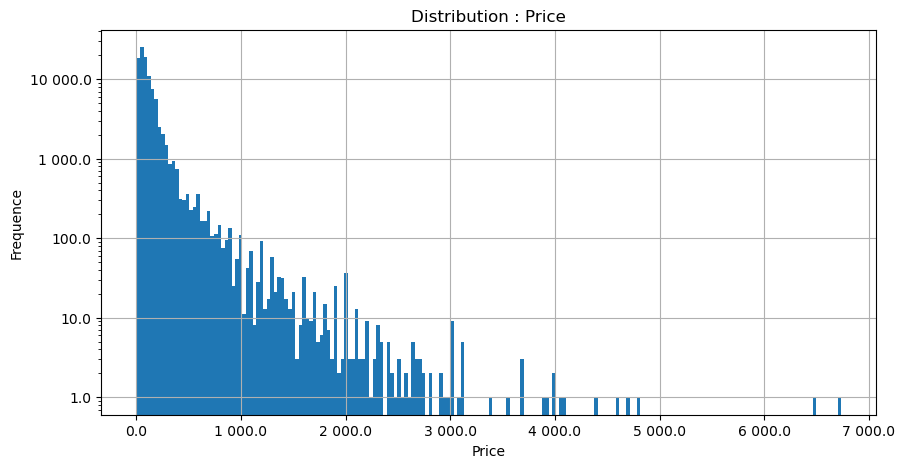

In [26]:
# distribution
hist = df["price"].hist(figsize=(10, 5), bins=200, log=True)
hist.yaxis.set_major_formatter(FuncFormatter(format_func))
hist.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.title("Distribution : Price")
plt.xlabel("Price")
plt.ylabel("Frequence")

**Commentaires :**  
Pour cette analyse, les outliers sont à conserver, ils sont nécessaire pour une segmentation plus détaillée.  
* Distribution asymétrique avec forts outliers == > une transformation logarithmique sera réalisée lors du preprocessing.

##### **B. Détails de la feature `freight_value` :**

Text(0, 0.5, 'Frequence')

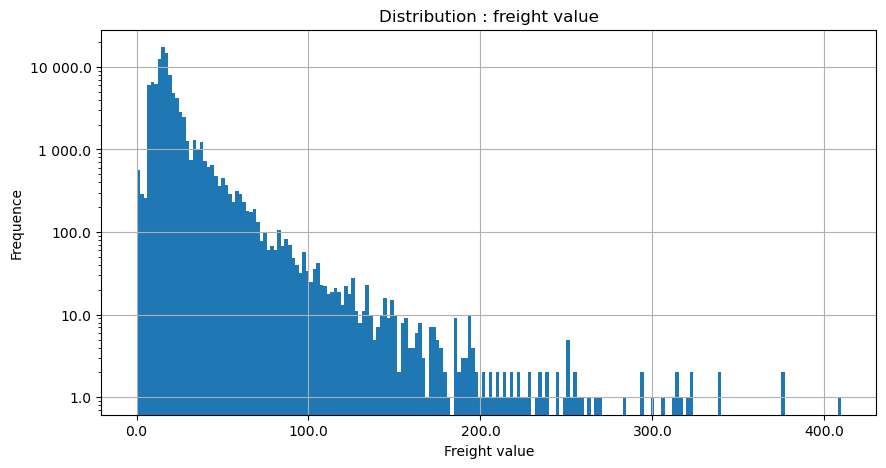

In [27]:
# distribution
hist = df["freight_value"].hist(figsize=(10, 5), bins=200, log=True)
hist.yaxis.set_major_formatter(FuncFormatter(format_func))
hist.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.title("Distribution : freight value")
plt.xlabel("Freight value")
plt.ylabel("Frequence")

**Commentaires :**  
Ides feature `price`, les outliers sont à conserver.  
* Une transformation logarithmique sera réalisée lors du preprocessing.

##### **C. Détails de la feature  `product_category_name_english` :**

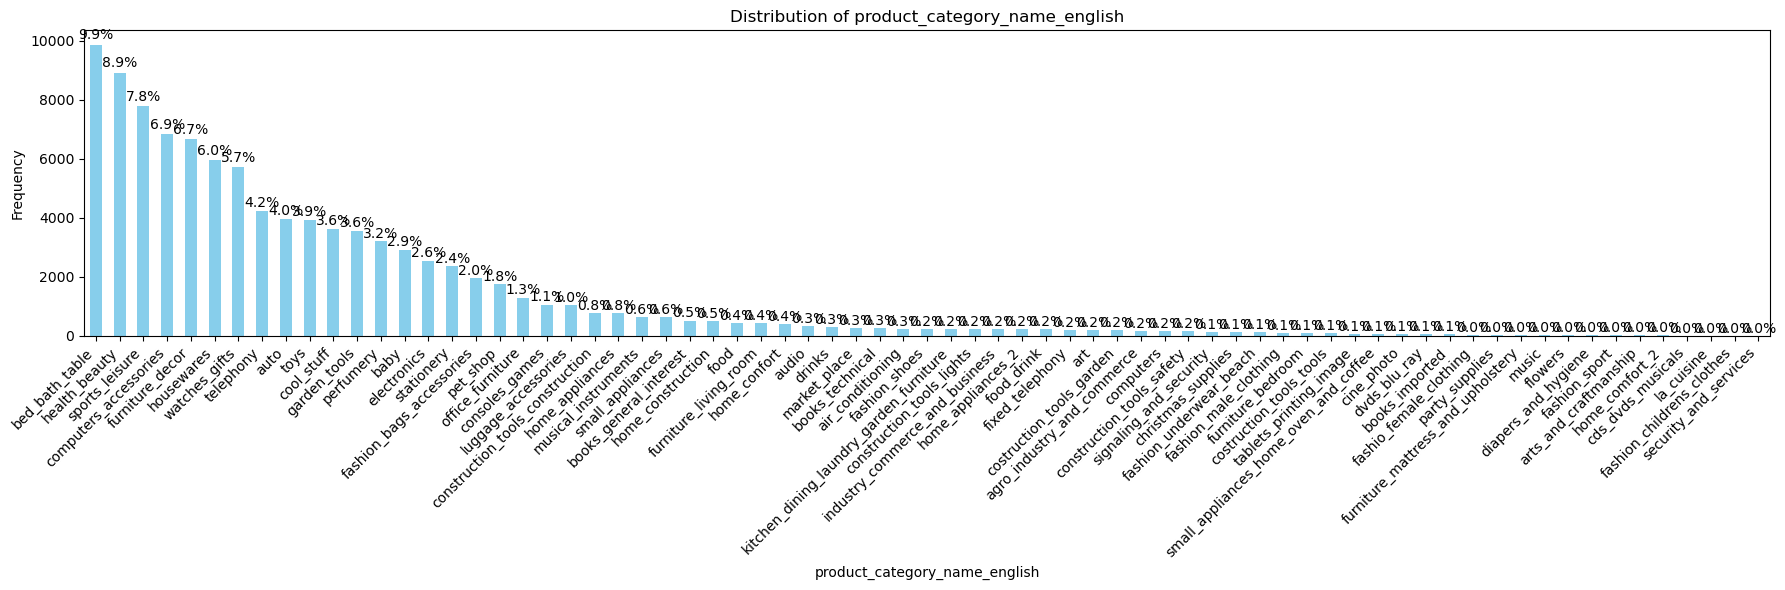

In [28]:
# distribution
plot_categorical_distribution(df, "product_category_name_english", (18, 6))

**Commentaires :**  
Beaucoup de catégories : 71  
Principales catégories vendues :
* ameublement
* produits de beauté
* loisirs sportifs
* accessoires informatiques
* décoration
* ...

**D. Corrélation des features :**

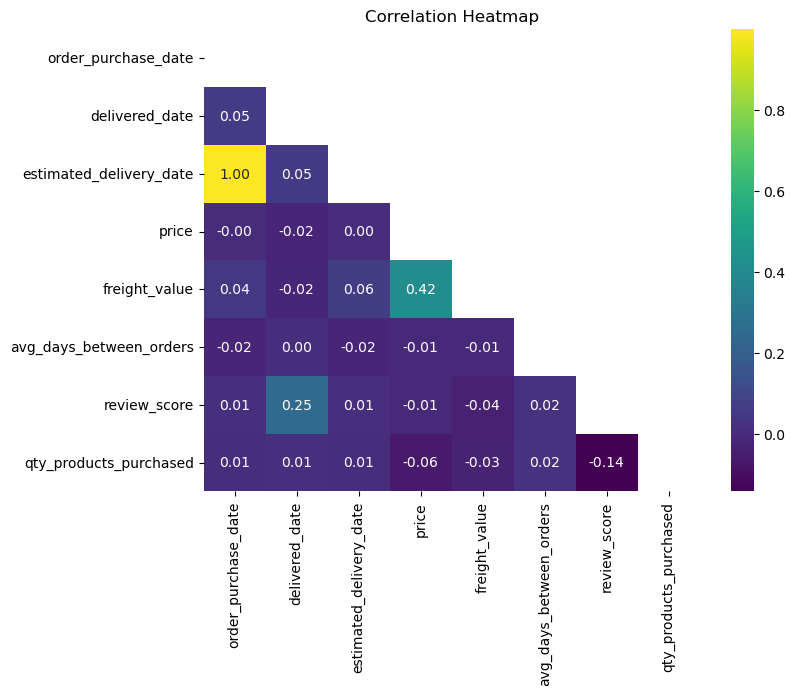

In [29]:
# correlation matrix 
correlation_matrix = df.select_dtypes(exclude="object").corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix, 
    mask=mask, 
    annot=True, 
    cmap="viridis", 
    fmt=".2f"
)
plt.title("Correlation Heatmap")
plt.show()

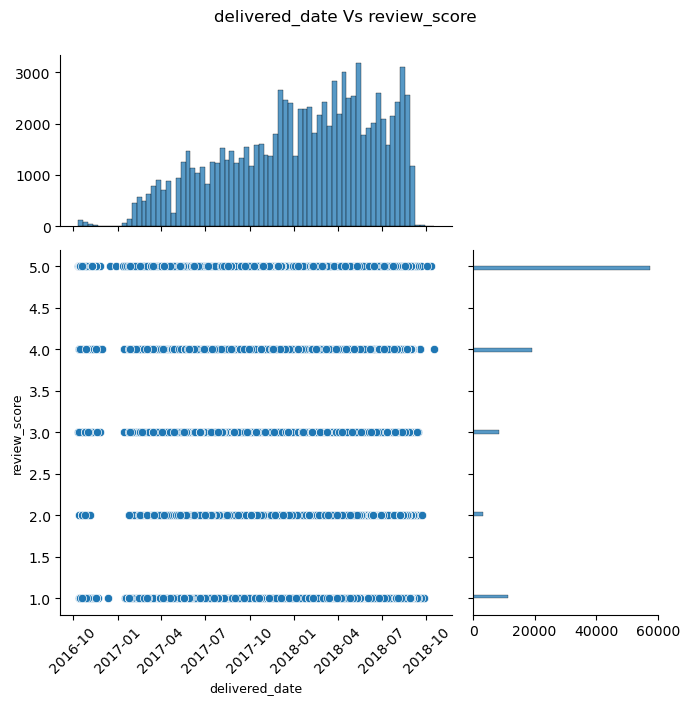

In [30]:
# plot delivered_date vs review_score
g = sns.jointplot(data=df, x="delivered_date", y="review_score", height=5, ratio=2, marginal_ticks=True)
g.fig.set_size_inches(7, 7)
plt.setp(g.ax_joint.get_xticklabels(), rotation=45)
g.fig.suptitle('delivered_date Vs review_score', y=1)  
g.ax_joint.set_xlabel('delivered_date', fontsize=9)
g.ax_joint.set_ylabel('review_score', fontsize=9)
plt.tight_layout()
plt.show()

**Commentaires :**  
* Corrélation entre les dates de commandes et d'estimation de livraison n'a pas d'importance, les dates serviront uniquement pour de nouvelles features.
* La corrélation entre le prix et les frais de port ne nous intéresse pas, les deux valeurs seront sommées.
* Légère corrélation entre la date de livraison et le score donné à 0.25

---
---
### 2.4 - Feature Engineering :

**Création de features :**  

Premier temps (par commande):
* **Livraison reçue** :  `received` == 1
* **Livraison non reçue** :  `not_received` == 1
* **Livraison reçue avant estimation** : `in_time` == 1
* **Livraison reçue après estimation** : `late` == 1

Deuxième temps :
* **Fichier par client** : aggrégation
* **Récence d'achat** : nbre de jour entre le 2018-09-03 et la date de la dernière commande - `recence`
* **Fréquence d'achat** : nbre de commandes passées - `frequence`
* **Montant total dépensé** - `sum_payments`
* **Diversité des produits** : compter le nombre de catégories de produits achetés par client - `count_category_purchased`
* **Diversité des vendeurs** : compter le nombre de vendeurs différents chez qui un client a acheté - `qty_seller`
* **Satisfaction client** : score moyen donné aux vendeurs - `mean_review_score`
* **Livraison** : compter le nombre de commandes reçues / non reçues / reçues à temps / reçues en retard - `order_received`, `order_not_received`, `order_in_time`, `order_late`

In [31]:
df.columns

Index(['customer_unique_id', 'order_id', 'order_purchase_date',
       'delivered_date', 'estimated_delivery_date', 'order_status',
       'seller_id', 'price', 'freight_value', 'product_category_name_english',
       'customer_city', 'avg_days_between_orders', 'review_score',
       'qty_products_purchased'],
      dtype='object')

---
#### 2.4.1 - Création Features - Livraison par commande :

S'il existe une date `delivered_date` ==> `received` = 1  
Si pas de date `delivered_date` ==> `not_received` = 1   
Si `delivered_date` < `estimated_delivery_date` ==> `in_time` = 1  
Si `delivered_date` > `estimated_delivery_date` ==> `late` = 1  

In [32]:
# binary features for "received" / "not received" order
df["received"] = np.where(pd.notna(df["delivered_date"]), 1, 0)
df["not_received"] = np.where(pd.isnull(df["delivered_date"]), 1, 0)

In [33]:
# binary features for "in time" / "late" order
df["in_time"] = np.where(df["delivered_date"] < 
                         df["estimated_delivery_date"], 1, 0)
df["late"] = np.where(df["delivered_date"] > 
                      df["estimated_delivery_date"], 1, 0)

---
#### 2.4.2 - Création de la feature  `recence` : (en mois)

In [34]:
# create recence feature in month
average_days_per_month = 30.44
df["recence_order_month"] = (
    df["order_purchase_date"].max() - df["order_purchase_date"]
).dt.days / average_days_per_month

---
#### 2.4.3 - Création Feature montant total par commande :

In [35]:
# feature "total_payment" with sum of "price" and "freight_value"
df["total_payment"] = df["price"] + df["freight_value"]

---
#### 2.4.4 - Aggrégation et calculs :

Aggrégation afin d'avoir un dataframe contenant 1 ligne par client.

In [36]:
# aggregated dataframe and various calculations for new features
df_agg = df.groupby(by="customer_unique_id").agg(
    frequence=("order_id", "count"),
    recence=("recence_order_month", "min"),
    recence_date=("order_purchase_date", "max"),
    sum_payments=("total_payment", "sum"),
    count_category_purchased=("product_category_name_english", "nunique"),
    qty_seller=("seller_id", "nunique"),
    mean_review_score=("review_score", "mean"),
    order_received=("received", "sum"),
    order_not_received=("not_received", "sum"),
    order_in_time=("in_time", "sum"),
    order_late=("late", "sum"),
    
)

In [37]:
# retrieving features already created in SQL to merge them
df_temp = df.drop(
    columns=[
        "order_id",
        "seller_id",
        "price",
        "freight_value",
        "review_score",
        "qty_products_purchased",
        "total_payment",
        "order_purchase_date",
        "order_status",
        "received",
        "not_received",
        "in_time",
        "late",
        "product_category_name_english",
        "delivered_date",
        "estimated_delivery_date",
        "recence_order_month"
    ]
)

In [38]:
df_temp_unique = df_temp.drop_duplicates(subset=["customer_unique_id"])

In [39]:
# merge df_agg and df_temp_unique
from functools import reduce

dfs = [df_agg, df_temp_unique]
final_df = reduce(
    lambda left, right:
    pd.merge(left, right, on=["customer_unique_id"], how="inner"),
    dfs)

In [40]:
final_df.sample(10)

,customer_unique_id,frequence,recence,recence_date,sum_payments,count_category_purchased,qty_seller,mean_review_score,order_received,order_not_received,order_in_time,order_late,customer_city,avg_days_between_orders
92182,fcb030a53d324f1642eeed9a05c75d7d,1,17.148489,2017-03-29 22:02:57,114.86,1,1,5.0,1,0,1,0,sao bento do sul,0.0
18568,32a86b4104156ff372232e52478e7f86,1,2.660972,2018-06-13 09:18:06,83.21,1,1,5.0,1,0,1,0,uberlandia,0.0
19472,351e8eac3f1dc8843d6c2f627ef66179,1,5.026281,2018-04-02 11:42:32,132.84,1,1,5.0,1,0,1,0,teofilo otoni,0.0
38729,69dbe3694c52cd73bcbf1bc7b0d5d3ab,1,6.307490,2018-02-22 23:30:05,86.02,1,1,1.0,1,0,0,1,cerqueira cesar,0.0
28542,4e028cda495e1923851032da7ce43a4b,1,4.139290,2018-04-29 15:18:48,77.49,1,1,5.0,1,0,1,0,conchal,0.0
36739,645f6703f46a173dd70f5ee24ea27176,1,11.695138,2017-09-11 20:00:32,68.23,1,1,1.0,1,0,1,0,sao paulo,0.0
77140,d30558fa40a69e6c76998b56a2e5b3a8,1,13.009198,2017-08-02 22:29:10,142.26,1,1,5.0,1,0,1,0,rio de janeiro,0.0
36960,64fb97eecb229bb89643a88e5b54d614,1,2.102497,2018-06-30 13:21:53,59.06,1,1,3.0,1,0,1,0,xinguara,0.0
23551,405f1175ae2417fb0afcbb89f5b45bdc,1,14.848883,2017-06-07 11:49:07,33.90,1,1,5.0,1,0,1,0,cotia,0.0
1851,050331c7df0a0d54e5dd22f4fae0f2c4,1,2.562418,2018-06-16 15:20:44,118.60,1,1,5.0,1,0,1,0,fortaleza,0.0


In [41]:
# set index to 'customer_unique_id'
final_df = final_df.set_index("customer_unique_id")

In [42]:
final_df.isnull().sum()

frequence                   0
recence                     0
recence_date                0
sum_payments                0
count_category_purchased    0
qty_seller                  0
mean_review_score           0
order_received              0
order_not_received          0
order_in_time               0
order_late                  0
customer_city               0
avg_days_between_orders     0
dtype: int64

In [43]:
final_df.describe()

,frequence,recence,recence_date,sum_payments,count_category_purchased,qty_seller,mean_review_score,order_received,order_not_received,order_in_time,order_late,avg_days_between_orders
count,93396.000000,93396.000000,93396,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000,93396.000000
mean,1.066288,7.941664,2018-01-03 23:48:03.407287296,154.516834,1.024990,1.037261,4.104500,1.044156,0.022132,0.962097,0.082059,2.032308
min,1.000000,0.000000,2016-09-04 21:15:19,9.590000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.876478,2017-09-16 21:42:42.249999872,59.407500,1.000000,1.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,7.293035,2018-01-23 13:21:13,101.140000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,11.530880,2018-05-07 21:24:43,171.830000,1.000000,1.000000,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,15.000000,23.915900,2018-09-03 09:06:57,7571.630000,5.000000,10.000000,5.000000,14.000000,4.000000,14.000000,4.000000,364.975683
std,0.312979,5.031693,NaN,206.137697,0.167607,0.214380,1.324574,0.343594,0.150636,0.433584,0.281581,19.304089


---
#### 2.4.5 - Exportation du dataset en csv :

In [44]:
final_df.head()

,frequence,recence,recence_date,sum_payments,count_category_purchased,qty_seller,mean_review_score,order_received,order_not_received,order_in_time,order_late,customer_city,avg_days_between_orders
customer_unique_id,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,3.777924,2018-05-10 10:56:27,141.90,1,1,5.0,1,0,1,0,cajamar,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,3.876478,2018-05-07 11:11:27,27.19,1,1,4.0,1,0,1,0,osasco,0.0
0000f46a3911fa3c0805444483337064,1,17.772668,2017-03-10 21:05:03,86.22,1,1,3.0,1,0,1,0,sao jose,0.0
0000f6ccb0745a6a4b88665a16c9f078,1,10.676741,2017-10-12 20:29:41,43.62,1,1,4.0,1,0,1,0,belem,0.0
0004aac84e0df4da2b147fca70cf8255,1,9.592641,2017-11-14 19:45:42,196.89,1,1,5.0,1,0,1,0,sorocaba,0.0


In [45]:
final_df.to_csv("data/cleaned/export_all_features.csv")

In [46]:
final_df.shape

(93396, 13)

Text(0, 0.5, 'Frequence')

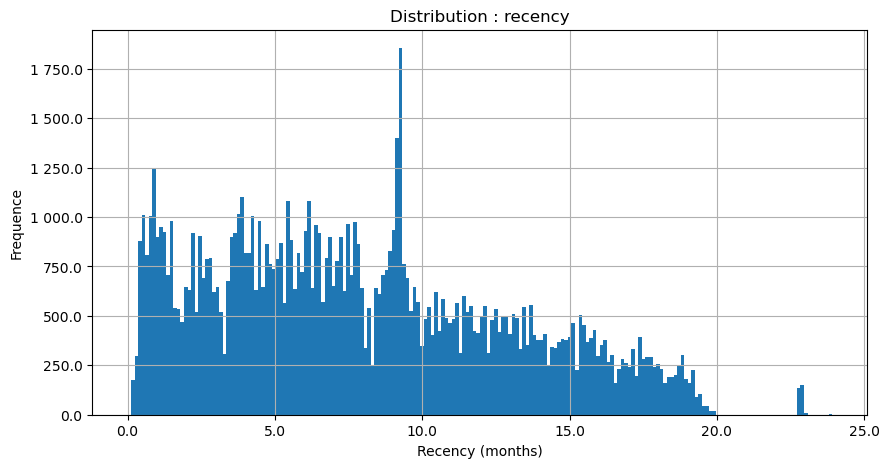

In [58]:
# distribution
hist = final_df["recence"].hist(figsize=(10, 5), bins=200, )
hist.yaxis.set_major_formatter(FuncFormatter(format_func))
hist.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.title("Distribution : recency")
plt.xlabel("Recency (months)")
plt.ylabel("Frequence")

Text(0, 0.5, 'Frequence')

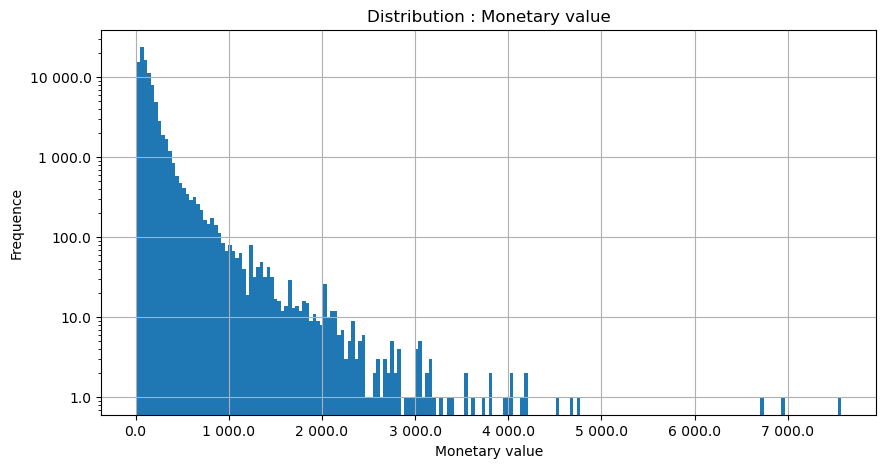

In [63]:
# distribution
hist = final_df["sum_payments"].hist(figsize=(10, 5), bins=200, log=True )
hist.yaxis.set_major_formatter(FuncFormatter(format_func))
hist.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.title("Distribution : Monetary value")
plt.xlabel("Monetary value")
plt.ylabel("Frequence")

Text(0, 0.5, 'Frequence')

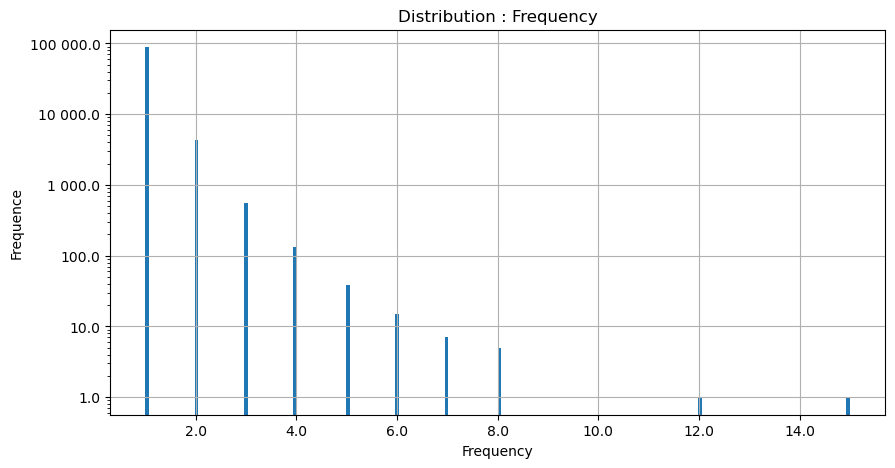

In [64]:
# distribution
hist = final_df["frequence"].hist(figsize=(10, 5), bins=200, log=True )
hist.yaxis.set_major_formatter(FuncFormatter(format_func))
hist.xaxis.set_major_formatter(FuncFormatter(format_func))
plt.title("Distribution : Frequency")
plt.xlabel("Frequency")
plt.ylabel("Frequence")

<Axes: xlabel='mean_review_score'>

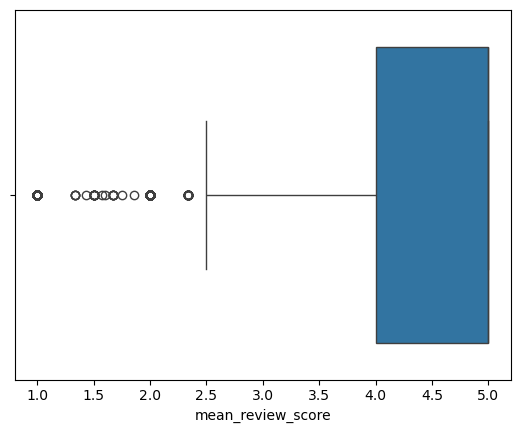

In [52]:
sns.boxplot(x="mean_review_score", data=final_df)